In [ ]:
#Dataset path
path = 'AM_MAsterData.csv'

## Target Feature Analysis

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def analyze_target_relationships(df_path, target='Aspect Ratio (H/W)'):
    """
    Analyze relationships between target variable and independent features
    
    Parameters:
    df (pd.DataFrame): Input dataframe
    target (str): Name of target variable
    """
    #Reading the df file
    df = pd.read_csv(df_path)

    # Get independent numerical features
    independent_features = [col for col in df.select_dtypes(include=['int64', 'float64']).columns 
                          if col != target]
    
    # Calculate number of rows and columns for subplot grid
    n_features = len(independent_features)
    n_cols = 2  # 2 plots per row
    n_rows = (n_features + 1) // 2  # Ceiling division
    
    # Create figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    fig.suptitle(f'Relationship between {target} and Independent Features', 
                fontsize=16, y=1.02)
    
    # Flatten axes array for easier iteration
    axes = axes.flatten()
    
    # Create scatter plots with regression lines
    for idx, feature in enumerate(independent_features):
        # Create scatter plot
        sns.regplot(x=df[feature], y=df[target], ax=axes[idx],
                   scatter_kws={'alpha':0.5, 's':50}, 
                   line_kws={'color': 'red'})
    
        
        # Add grid
        axes[idx].grid(True, linestyle='--', alpha=0.7)
        
        # Improve layout
        axes[idx].set_xlabel(feature)
        axes[idx].set_ylabel(target)
    
    # Remove empty subplots if any
    for idx in range(len(independent_features), len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    plt.show()
    

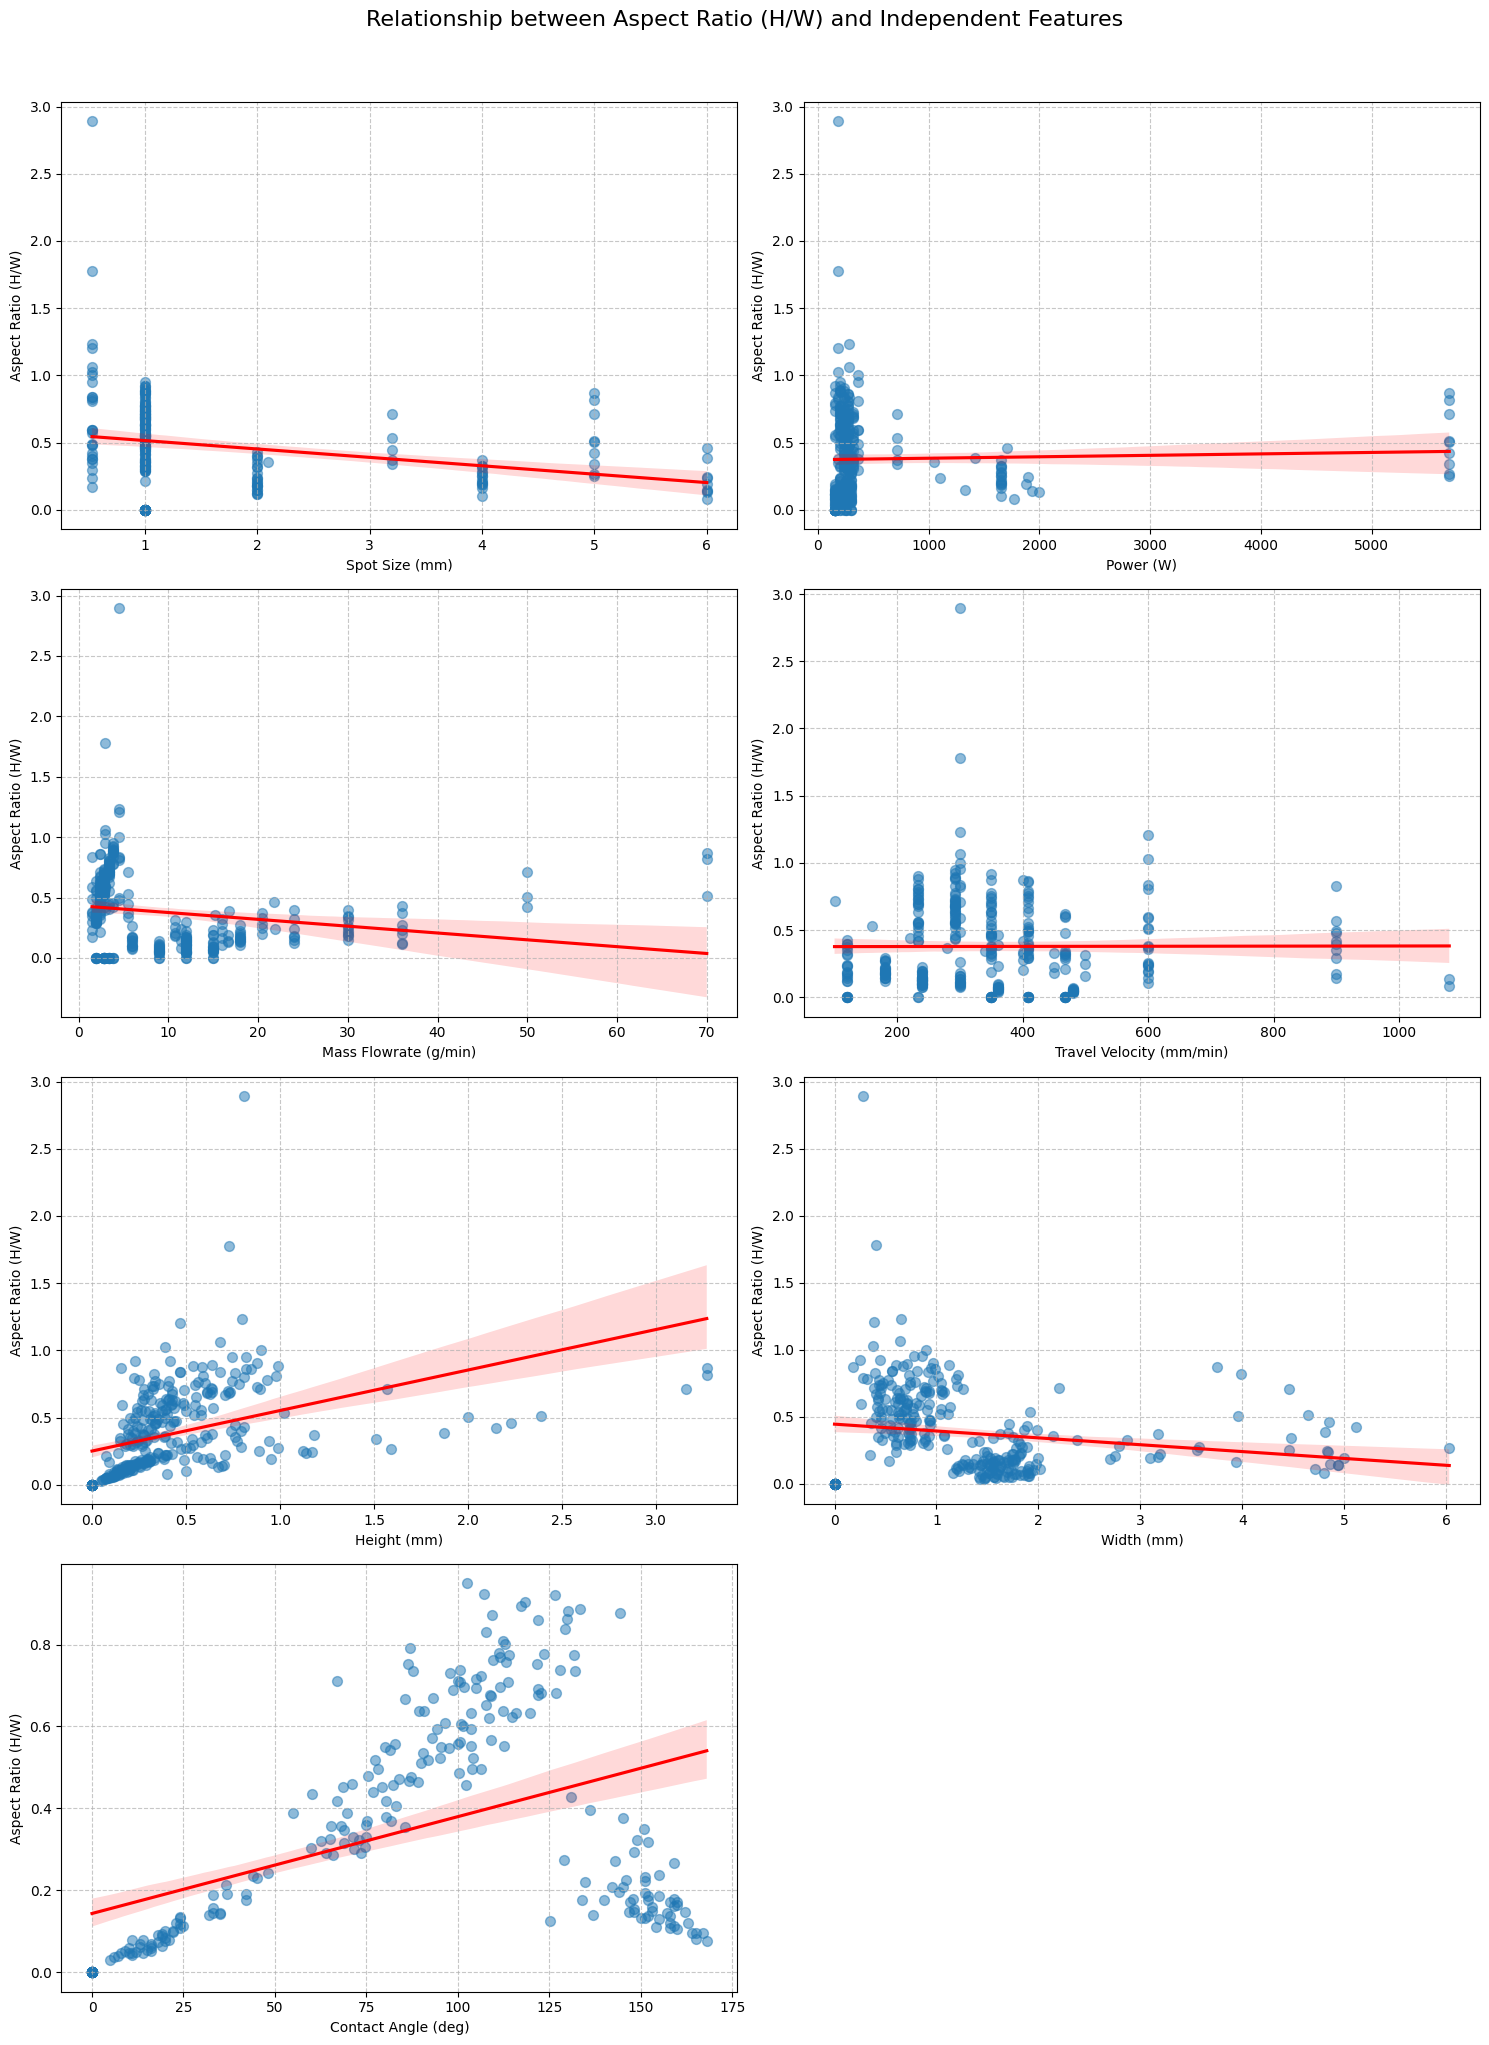

In [14]:
analyze_target_relationships(path)

1 - Here we can see that the features which affect the 'aspect ratio' are `Contact Angle`, `Height`,`mass flowrate`,`spot size`,`width`

2 - Next we will do feature importances step to gain more proof that `power` and `travel velocity` are not related

## Multi- Collinearity Check

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

def analyze_multicollinearity(df, target='Aspect Ratio (H/W)', vif_threshold=5, corr_threshold=0.7):
    """
    Analyze multicollinearity among independent features using VIF and correlation matrix
    
    Parameters:
    df (pd.DataFrame): Input dataframe
    target (str): Name of target variable
    vif_threshold (float): Threshold for VIF values (default=5)
    corr_threshold (float): Threshold for correlation values (default=0.7)
    """
    
    # Get independent numerical features
    independent_features = [col for col in df.select_dtypes(include=['int64', 'float64']).columns 
                          if col != target]
    
    # Create clean dataset for analysis
    df_clean = df[independent_features].copy()
    df_clean = df_clean.replace([np.inf, -np.inf], np.nan)
    df_clean = df_clean.dropna()
    
    print("1. VIF Analysis:")
    print("-" * 50)
    
    # Calculate VIF for each feature
    vif_data = pd.DataFrame()
    vif_data["Feature"] = independent_features
    vif_data["VIF"] = [variance_inflation_factor(df_clean[independent_features].values, i)
                       for i in range(len(independent_features))]
    
    # Sort by VIF value
    vif_data = vif_data.sort_values('VIF', ascending=False)
    print("\nVIF Values:")
    print(vif_data)
    
    print("\nFeatures with high VIF (>", vif_threshold, "):")
    print(vif_data[vif_data['VIF'] > vif_threshold])
    
    # Correlation Analysis
    print("\n2. Correlation Analysis:")
    print("-" * 50)
    
    # Calculate correlation matrix
    correlation_matrix = df_clean[independent_features].corr()
    
    # Find highly correlated feature pairs
    high_correlation = np.where(np.abs(correlation_matrix) > corr_threshold)
    high_correlation = [(correlation_matrix.index[x], correlation_matrix.columns[y], 
                        correlation_matrix.iloc[x, y])
                       for x, y in zip(*high_correlation)
                       if x != y and x < y]  # Remove diagonal and duplicate pairs
    
    print("\nHighly correlated feature pairs (correlation >", corr_threshold, "):")
    if high_correlation:
        for feat1, feat2, corr in high_correlation:
            print(f"{feat1} - {feat2}: {corr:.3f}")
    else:
        print("No highly correlated pairs found.")
    
    # Visualize correlation matrix
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
                square=True, linewidths=0.5, fmt='.2f', cbar_kws={"shrink": .8})
    plt.title('Correlation Matrix of Independent Features')
    plt.tight_layout()
    plt.show()
    
    
    # Recommendations based on analysis
    print("\n3. Recommendations:")
    print("-" * 50)
    
    high_vif_features = vif_data[vif_data['VIF'] > vif_threshold]['Feature'].tolist()
    
    if high_vif_features or high_correlation:
        print("\nConsider addressing multicollinearity by:")
        if high_vif_features:
            print("\nBased on VIF analysis:")
            for feature in high_vif_features:
                print(f"- Investigating feature: {feature} (VIF: {vif_data[vif_data['Feature']==feature]['VIF'].values[0]:.2f})")
        
        if high_correlation:
            print("\nBased on correlation analysis:")
            for feat1, feat2, corr in high_correlation:
                print(f"- Investigating relationship between {feat1} and {feat2} (correlation: {corr:.3f})")
        
        print("\nPossible solutions:")
        print("1. Feature selection: Remove one feature from each highly correlated pair")
        print("2. Feature combination: Create new features by combining correlated features")
        print("3. Principal Component Analysis (PCA)")
        print("4. Regular or elastic net regularization in modeling")
    else:
        print("No significant multicollinearity detected.")
    
    return {
        'vif_data': vif_data,
        'correlation_matrix': correlation_matrix,
        'high_correlation_pairs': high_correlation
    }

1. VIF Analysis:
--------------------------------------------------

VIF Values:
                    Feature        VIF
0            Spot Size (mm)  51.043478
5                Width (mm)  49.435903
1                 Power (W)  42.193690
3  Travel Velocity (mm/min)  12.620230
6       Contact Angle (deg)  10.739925
4               Height (mm)   8.487225
2     Mass Flowrate (g/min)   6.096092

Features with high VIF (> 5 ):
                    Feature        VIF
0            Spot Size (mm)  51.043478
5                Width (mm)  49.435903
1                 Power (W)  42.193690
3  Travel Velocity (mm/min)  12.620230
6       Contact Angle (deg)  10.739925
4               Height (mm)   8.487225
2     Mass Flowrate (g/min)   6.096092

2. Correlation Analysis:
--------------------------------------------------

Highly correlated feature pairs (correlation > 0.7 ):
Spot Size (mm) - Power (W): 0.932
Spot Size (mm) - Width (mm): 0.948
Power (W) - Width (mm): 0.912


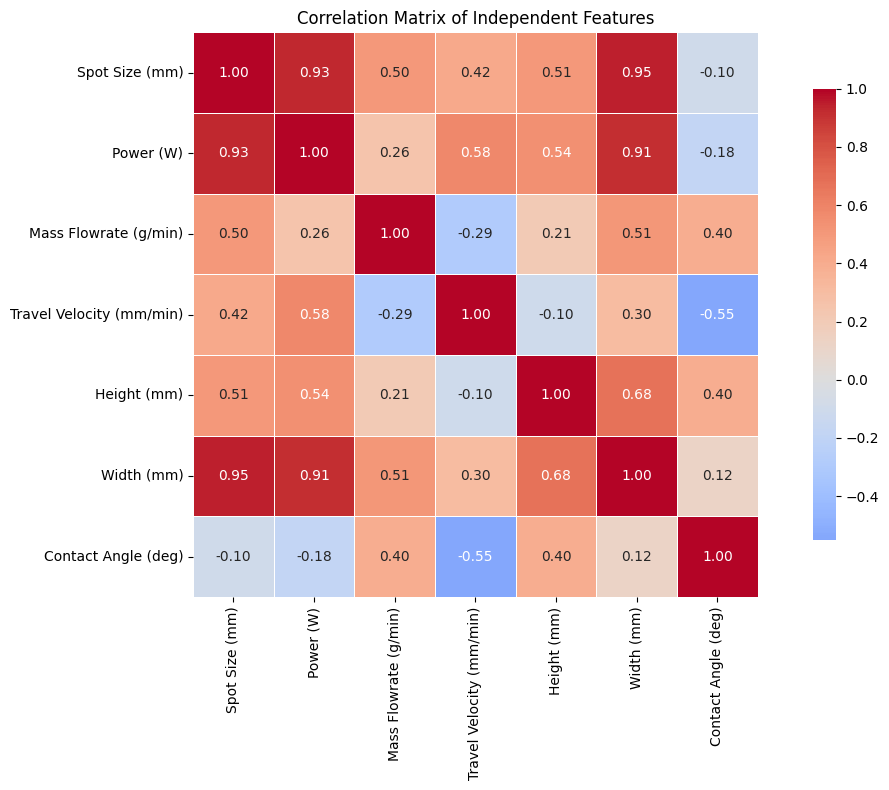


3. Recommendations:
--------------------------------------------------

Consider addressing multicollinearity by:

Based on VIF analysis:
- Investigating feature: Spot Size (mm) (VIF: 51.04)
- Investigating feature: Width (mm) (VIF: 49.44)
- Investigating feature: Power (W) (VIF: 42.19)
- Investigating feature: Travel Velocity (mm/min) (VIF: 12.62)
- Investigating feature: Contact Angle (deg) (VIF: 10.74)
- Investigating feature: Height (mm) (VIF: 8.49)
- Investigating feature: Mass Flowrate (g/min) (VIF: 6.10)

Based on correlation analysis:
- Investigating relationship between Spot Size (mm) and Power (W) (correlation: 0.932)
- Investigating relationship between Spot Size (mm) and Width (mm) (correlation: 0.948)
- Investigating relationship between Power (W) and Width (mm) (correlation: 0.912)

Possible solutions:
1. Feature selection: Remove one feature from each highly correlated pair
2. Feature combination: Create new features by combining correlated features
3. Principal Compone

{'vif_data':                     Feature        VIF
 0            Spot Size (mm)  51.043478
 5                Width (mm)  49.435903
 1                 Power (W)  42.193690
 3  Travel Velocity (mm/min)  12.620230
 6       Contact Angle (deg)  10.739925
 4               Height (mm)   8.487225
 2     Mass Flowrate (g/min)   6.096092,
 'correlation_matrix':                           Spot Size (mm)  Power (W)  Mass Flowrate (g/min)  \
 Spot Size (mm)                  1.000000   0.931938               0.499362   
 Power (W)                       0.931938   1.000000               0.257324   
 Mass Flowrate (g/min)           0.499362   0.257324               1.000000   
 Travel Velocity (mm/min)        0.416684   0.578498              -0.293507   
 Height (mm)                     0.506206   0.543611               0.210820   
 Width (mm)                      0.947846   0.912278               0.513833   
 Contact Angle (deg)            -0.095052  -0.176839               0.399535   
 
           

In [19]:
analyze_multicollinearity(path)

### 3 main approaches to handle high VIF features:

#### Iterative VIF Selection:

Remove highest VIF feature iteratively

Continue until all VIF values are below threshold

Pros: Simple, maintains interpretability

Cons: Might lose important information


#### Principal Component Analysis (PCA):

Transform correlated features into uncorrelated components

Retain components explaining desired variance

Pros: Captures maximum variance, removes multicollinearity

Cons: Loses direct feature interpretability


#### Feature Clustering:

Group correlated features into clusters

Select representative feature or create composite

Pros: Balance between interpretation and information

Cons: Requires choosing representative features



#### Recommendations for Usage:

<b>Choose Method Based on Goals:</b>

Need interpretability → Use VIF selection

Need maximum variance → Use PCA

Need balance → Use feature clustering


<b>Consider Domain Knowledge:</b>

Some features might be crucial despite high VIF

Domain expertise should guide feature selection


<b>Validate Results:</b>

Compare model performance with different approaches

Check if removing features impacts predictive power

### Analysis

1 - Features having vif > 10 are considered highly collinear. Some features might be crucial despite high VIF as per domain knowledge.

2 - Features `Spot Size`, `Width`, `Power`, `Travel Velocity`, `Contact Angle` have high multi collinearity.

3 - We will use Iterative VIF Selection as we want to preserve model interpretability